In [ ]:
%reset -f

## Data




In [ ]:
import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt

### Load

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

On ne garde pas toutes les images

In [ ]:
keept=8_000
train_images=train_images[:keept]
train_labels=train_labels[:keept]

train_images.shape

***A vous:*** C'est des images, alors affichez-les!

### Preprocess

In [ ]:
X_train=np.reshape(train_images/255,[-1,28*28])
X_test=np.reshape(test_images/255,[-1,28*28])

Y_train=train_labels
Y_test=test_labels

In [ ]:
X_train_torch=torch.tensor(X_train,dtype=torch.float32)
X_test_torch=torch.tensor(X_test,dtype=torch.float32)

Y_train_torch=torch.tensor(Y_train,dtype=torch.int64)
Y_test_torch=torch.tensor(Y_test,dtype=torch.int64)

Pour travailler sur gpu, ajouter `.to("cuda")` par exemple:

    X_train_torch=torch.tensor(X_train,dtype=torch.float32).to("cuda")


### Distributeur de batch

* Le mot "step" désigne en général une étape d'optimisation effectuée sur un "batch" de donnée.
* Le mot "epoch" désigne un grand ensemble de "step". A la fin de chaqué epoch on fait une étape de validation = on observe la loss (et autre métriques) sur des données de validation qui n'ont pas été vue par l'optimizer.



* Parfois les epoch sont constituées d'un nombre arbitraire de step.
* Mais quand le nombre de données est limité, la tradition c'est d'une epoch correspond au passage de toutes les données une fois. Dans ce cas le nombre de step par epoch c'est approximativement `nb_data//batch_size`.

Le programme suivant permet de découper toutes les données en batch.



In [ ]:
"""  distributeur de donnée par batch.   """
def oneEpoch(X_all,Y_all,batch_size):

    nb_batches=len(X_all)//batch_size

    shuffle_index=np.random.permutation(len(X_all))
    X_all_shuffle=X_all[shuffle_index]
    Y_all_shuffle=Y_all[shuffle_index]

    for i in range(nb_batches):
        yield X_all_shuffle[i*batch_size:(i+1)*batch_size],Y_all_shuffle[i*batch_size:(i+1)*batch_size]

***Moment python:***  Quand on a des slices qui se répettent, pour éviter la duplication de code on peut les définir ainsi:
    
    for i in range(nb_batches):
        sl=slice(i*batch_size,(i+1)*batch_size)
        yield X_all_shuffle[sl],Y_all_shuffle[sl]

Notons qu'au début de chaque epoch les données sont randomisées, afin qu'elle ne passe pas à chaque fois dans le même ordre dans l'optimizer.

Notez le mot clé `yield` qui caractérise la création d'un itérateur. C'est l'équivalent d'un `return` dans une boucle qui va s'exécuter au fur et à mesure. On utilise ensuite l'itérateur ainsi:

In [ ]:
#création de l'itérateur
batch_dealer=oneEpoch(X_train,Y_train,256)
#utilisation de l'itérateur
for X_batch,Y_batch in batch_dealer:
    print(X_batch.shape,Y_batch.shape)

### Distributeur sans perte

***Remarque:*** Avec notre technique, tous les batchs ont exactement la même taille, mais si le nombre de données n'est pas divsible par `batch_size`, on perd quelques données à la fin.

 Pour éviter cela, on pourrait faire ainsi:


In [ ]:
"""  distributeur de donnée par batch.   """
def oneEpoch_sansPerte(X_all,Y_all,batch_size):

    nb_batches=len(X_all)//batch_size+1

    shuffle_index=np.random.permutation(len(X_all))
    X_all_shuffle=X_all[shuffle_index]
    Y_all_shuffle=Y_all[shuffle_index]

    for i in range(nb_batches):
        yield X_all_shuffle[i*batch_size:(i+1)*batch_size],Y_all_shuffle[i*batch_size:(i+1)*batch_size]


Dans ce cas là, le dernier batch est plus court que les autres (quel taille a-t-il?). Mais parfois ça provoque un `nan` embêtant.

Annalysez puis modifiez `oneEpoch_sansPerte` pour éviter ce bug

#### → ♡♡

In [ ]:
def test(batch_size):
    data_size=100
    X=torch.rand(data_size,3)
    Y=torch.rand(data_size,2)

    model=torch.nn.Linear(3,2)

    ite=oneEpoch_sansPerte(X,Y,batch_size)

    for x,y in ite:
        y_pred=model(x)
        loss=torch.mean((y-y_pred)**2)
        print(loss)

In [ ]:
test(23)

In [ ]:
test(20)

## Entrainement

### Un agent

Un agent c'est un objet qui va entrainer un modèle.

In [ ]:
import copy
class Agent:

    def __init__(self,model,learning_rate,X,Y,batch_size):
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.model = model
        self.batch_size=batch_size
        nb_data_train=int(len(X)*0.8)
        self.X_train=X[:nb_data_train]
        self.Y_train=Y[:nb_data_train]
        self.X_val=X[nb_data_train:]
        self.Y_val=Y[nb_data_train:]

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.losses=[]
        self.val_steps=[]
        self.val_losses=[]
        self.step_count=-1


    def train_step(self,x,y):
        pred = self.model(x)
        loss = self.loss_fn(pred,y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss


    def val_step(self,x,y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fn(pred,y)
        return loss

    def train(self,nb_epochs):
        for _ in range(nb_epochs):
            for x,y in oneEpoch(self.X_train,self.Y_train,self.batch_size):
                self.step_count+=1
                loss=self.train_step(x,y)
                self.losses.append(loss.detach().cpu().numpy())

            val_loss=self.val_step(self.X_val,self.Y_val).cpu().numpy()
            self.val_losses.append(val_loss)

            if val_loss<=np.min(self.val_losses):
                print(f"⬊{val_loss:.2f}",end="")
                self.best_weights=copy.deepcopy(self.model.state_dict())
            else:
                print("⬈",end="")

            self.val_steps.append(self.step_count)

    def set_model_at_best(self):
        self.model.load_state_dict(self.best_weights)

### Modèle

#### →♡

In [ ]:
class Model_classif(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        self.lay1=torch.nn.Linear(784,hidden_dim)
        self.lay2=torch.nn.Linear(hidden_dim,hidden_dim)
        self.lay3=torch.nn.Linear(hidden_dim,hidden_dim)
        self.final_layer=...

    def forward(self, x):
        x=torch.relu(self.lay1(x))
        x=torch.relu(self.lay2(x))
        x=torch.relu(self.lay3(x))
        return self.final_layer(x)

def test():
    X=torch.rand(1,784)
    model=Model_classif(50)
    Y_pred=model(X)
    print(Y_pred.shape)
test()

    torch.Size([1, 10])

### C'est parti

In [ ]:
batch_size=256
learning_rate=1e-3
hidden_dim=50
model=Model_classif(hidden_dim)

In [ ]:
agent=Agent(model,learning_rate,X_train_torch,Y_train_torch,batch_size)

In [ ]:
agent.train(100)

In [ ]:
plt.plot(agent.losses)
plt.plot(agent.val_steps,agent.val_losses,"r.");

In [ ]:
def accuracy_test(model):
    with torch.no_grad():
        Y_pred_logits=model(X_test_torch).cpu().numpy()
        Y_pred=np.argmax(Y_pred_logits,axis=1)
    return np.mean(Y_pred==Y_test)

In [ ]:
def loss_test(model):
    loss_fn=torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        Y_pred_proba=model(X_test_torch)
    return loss_fn(Y_pred_proba,Y_test_torch).cpu().numpy()

In [ ]:
loss_test(agent.model)

In [ ]:
accuracy_test(agent.model)

In [ ]:
agent.set_model_at_best()
loss_test(agent.model)

In [ ]:
accuracy_test(agent.model)

Remarque: parfois l'accuracy du model "at best" n'est pas meilleure que celle du modèle à la fin de l'entrainement. Accuracy et loss ne sont liés qu'indirectement.


***A vous:*** Sans redéfinir le modèle, faites tourner une seconde fois la méthode `agent.train(10)`. Vous devrez optenir une courbe de loss comme ci-dessous. Expliquez pourquoi.

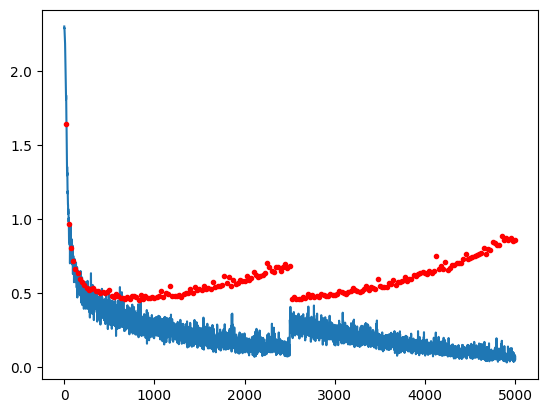

## Lutter contre le sur-apprentissage


Durant l'entrainement d'un modèle on assiste à une tension entre l'optimisation et la généralisation.
* "optimisation" permet au modèle de coller aux données train dont on dispose maintenant
* "généralisation" permet au modèle de coller aux données que l'on aura à traiter dans le futur: donc des données que le modèle n'a jamais vu. Pour "simuler" ces données, on utilise le jeu de validation durant l'entrainement, et à la toute fin,  le jeu test.

Au début de l'entrainement, l'optimisation et la généralisation s'améliorent conjointement: La loss sur le jeu train et validation descendent.  Mais après un certain nombre de passage sur les données train, la généralisation cesse de s'améliorer. Les métriques de validation commencent à se dégrader: le modèle commence alors à être surajusté, c'est-à-dire qu'il commence à apprendre des détails spécifiques aux données train, mais qui ne sont pas  pertinents pour de futurs données entrentes.

Le terme "régularisation des modèles" et synomime de "lutter contre le sur-apprentissage". Régulariser=lisser=ignorer les détails.


Examinons quelques-unes des techniques de régularisation.




### Early stopping

C'est la technique qu'il faut systèmatiquement implémenter:

A chaque étape de validation on calcul une `val_loss`. Si celle-ci atteint un nouveau record, on enregistre les paramètres du modèle. A la fin de l'entrainement, on attribu au modèle les derniers paramètres enregistrés (ceux où la `val_loss` était la plus basse).


Variante: On garde les paramètres relatifs aux $n$ records (ex $n=3$). Puis à la fin on attribu au modèle la moyenne de ces "bons" paramètres. Par exemple imaginons un réseau de neurone à 2 couche:
$$
    \text{Model}(x) =   (\sigma(x \cdot w+b)) \cdot w' + b'
$$
On a enregistré les paramètres des 3 records.
$$
    (w_t,w'_t,b_t,b'_t)_ {t \in 0,1,2}
$$
Le modèle final c'est
$$
    \text{Model}(x) =   (\sigma(x \cdot \bar w+ \bar  b)) \cdot \bar w' + \bar b'
$$
avec
$$
\bar w = {w_0+w_1+w_2 \over 3},\bar w' = {w'_0+w'_1+w'_2 \over 3}, \bar b = {b_0+b_1+b_2 \over 3},\bar b' = {b'_0+b'_1+b'_2 \over 3}
$$
Cette technique permet une meilleurs "généralisation" puisque les paramètres "moyen" décrivent des données plus "génériques".





### En registrer les poids du modèle sur le disque dur


Dans notre agent nous avons enregistrer les meilleurs poids du modèle dans un attribut `best_weights` de l'objet Agent. Ces poids sont donc uniquement mémorisés dans la mémoire de l'ordinateur.

Si on a des entrainements long que l'on a pas envie de refaire à chaque fois, on peut enregisrer les poids du modèle sur le disque dur, ainsi:


    def train(self,nb_epochs):
            for _ in range(nb_epochs):
                ...

                if val_loss<=np.min(self.val_losses):
                    torch.save(self.model.state_dict(), f'model_weights_{self.name}.pth')
                else:
                    print("⬈",end="")

        def set_model_at_best(self):
            self.model.load_state_dict(torch.load(f'model_weights_{self.name}.pth'))

où `self.name` est un attribut qu'on a ajouté pour nomer notre agent.




### Enregistrer tout le modèle sur le disque dur

La technique suivante permet même d'enregistrer un modèle avec tous ses paramètres et ses hyper-paramètres (donc toute son architecture).

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth')

### La librairie `pickel`


Notez que `torch.save` et `torch.load` sont basées sur la lib `pickel` qui enregistre n'importe quel objet python (super pratique).

Mais attention, pickle se base sur les codes "vivants" ce qui la rend sensible au mis à jour. Observons

In [ ]:
import pickle

class Homme:
    def __init__(self, age,nom):
        self.age=age
        self.nom=nom

    def make_me_older(self):
        self.age+=1

    def print_me(self):
        print(f"Je m'appelle {self.nom} et j'ai {self.age} ans")

homme=Homme(12,"toto")
homme.make_me_older()
homme.print_me()

In [ ]:
#enregistrement sur le disque dur de l'objet avec tous ses attributs
pickle.dump(homme,open("toto","wb"))

Maintenant Redémarer l'ordinateur. Dans colab:

    Excécution > Redémarer l'environement d'excécution

 Puis compiler la suite (notez la mise à jour de notre classe):

In [ ]:
class Homme:
    def __init__(self, age,nom):
        self.age=age
        self.nom=nom

    def make_me_older(self):
        self.age+=1

    def print_me(self):
        print(f"my name is {self.nom} and I'm {self.age} year old.")

In [ ]:
import pickle

homme_back=pickle.load(open("toto","rb"))
homme_back.make_me_older()
homme_back.print_me()

### Augmenter le nombre de données


Sans doute la meilleures et toutes les techniques. Plus on a de données d'entrainement, et plus elles pourront se généraliser.


Mais souvent le nombre de données est limité. Pour certaines données, comme des images, on peut créer de nouvelles données en introduisant des rotation/translation/changement d'éclairages.


***A vous:*** Jouez sur le paramètre `keept` pour montrer qu'en augmentant le nombre de données on diminue le sur-apprentissage.




### Diminuer le nombre de paramètres

En apprentissage profond, le nombre de paramètres apprenables dans un modèle est souvent appelé la "capacité" du modèle. Intuitivement, un modèle avec plus de paramètres aura une plus grande "capacité de mémorisation" et sera donc capable d'apprendre par coeur toute sorte de détail inutile.

Il y a donc un compromis à trouver entre "trop de capacité" et "pas assez de capacité".

Malheureusement, il n'existe pas de formule magique pour déterminer le bon nombre de couches, ou la bonne taille de chaque couche.  on dit souvent que:
* 3 couches c'est le minimum pour des données complexes.
* Quand on a des données structurée de manière hiérarchiques, comme des images, il faut mettre beaucoup de couche (mais ensuite on peut avoir des problèmes de "disparition de gradient).

En général on essaye de trouver une bonne architecture en augmentant progressivement la capicité.

***A vous:*** Faites-le en jouant sur le paramètre `hidden_dim`, ou bien ajouter/supprimer des couches.

### Pénaliser

C'est rendre le modèle moins performant pendant l'apprentissage, pour qu'il s'ajuste moins au données. On verra cela dans le prochain TP